In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor
import os
%run diagnostics.ipynb
import numpy as np
import pandas as pd

In [5]:
train_data_s = pd.read_csv(os.path.normpath(os.path.join(os.getcwd(), '../data/processed/train_data.csv')))
test_data_s = pd.read_csv(os.path.normpath(os.path.join(os.getcwd(), '../data/processed/test_data.csv')))


train_data = train_data_s.drop(columns=['session_seen', 'session_correct'])
test_data = test_data_s.drop(columns=['session_seen', 'session_correct'])

In [5]:
# train_data_s.to_csv(os.path.normpath(os.path.join(current_dir, '../data/processed/train_data.csv')))
# test_data_s.to_csv(os.path.normpath(os.path.join(current_dir, '../data/processed/test_data.csv')))

In [6]:
label = 'p_recall'
presets = 'best_quality'
excl_model_types =['NeuralNetTorch', 'NeuralNetFastAI', 'KNeighborsDist', 'KNeighborsUnif', 'LightGBM', 'LightGBMXT', 'RandomForestMSE']
incl_model_types = ['XGBoost']

In [91]:
# predictor = TabularPredictor(label=label).fit(train_data, included_model_types = ['XGB'], auto_stack = False,
#                                              save_space = True)

No path specified. Models will be saved in: "AutogluonModels/ag-20250320_114043"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.3
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:13:18 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       7.71 GB / 36.00 GB (21.4%)
Disk Space Avail:   125.59 GB / 460.43 GB (27.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accurac

In [7]:
# To use previously made predictor
# predictor = TabularPredictor.load("/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250318_141114")

predictor = TabularPredictor.load("/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250320_114043")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [34]:
# predictor.fit_extra(
#     hyperparameters={
#         'XGB': {}, 
#         'CAT': {}
#     }
)

Fitting 2 L1 models, fit_strategy="sequential" ...
Fitting model: CatBoost ...
	-0.2617	 = Validation score   (-root_mean_squared_error)
	12263.16s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2614	 = Validation score   (-root_mean_squared_error)
	31137.01s	 = Training   runtime
	4.08s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'XGBoost': 0.7, 'CatBoost': 0.3}
	-0.2613	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250318_141114")


In [8]:
models = predictor.model_names()
models

['XGBoost', 'WeightedEnsemble_L2']

In [9]:
print('best model:', predictor.model_best)

best model: WeightedEnsemble_L2


In [10]:
y_pred = predictor.predict(test_data.drop(columns=[label]), model=models[1])
# predictor.predict(test_data, model=models[1])
y_pred = cap_y(y_pred)

y_pred.head()

0    0.889664
1    0.879037
2    0.823844
3    0.892473
4    0.950383
Name: p_recall, dtype: float32

In [11]:
y_test = test_data['p_recall']


results_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred, 'session_seen':test_data_s['session_seen'], 
                          'session_correct':test_data_s['session_correct']})
results_df.head()

,y_test,y_pred,session_seen,session_correct
0,1.000000,0.889664,1,1
1,0.857143,0.879037,7,6
2,0.875000,0.823844,8,7
3,1.000000,0.892473,1,1
4,1.000000,0.950383,2,2


In [12]:
print('mae:', (results_df['y_test'] - results_df['y_pred']).abs().mean())

mae: 0.16324087337547905


In [13]:
predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -0.26245380113677613,
 'mean_squared_error': -0.06888199773114242,
 'mean_absolute_error': -0.16330550503113841,
 'r2': 0.05643623270701903,
 'pearsonr': 0.23756440369631815,
 'median_absolute_error': -0.09711545705795288}

In [14]:
predictor.info()

{'path': '/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250320_114043',
 'label': 'p_recall',
 'random_state': 0,
 'version': '1.2',
 'features': ['Unnamed: 0',
  'word_len',
  'tags_list',
  'SUBTLEX',
  'delta',
  'history_seen',
  'history_correct',
  'h_recall',
  'lang_combination',
  'avg_delta',
  'std_delta',
  'avg_h_recall'],
 'feature_metadata_in': <autogluon.common.features.feature_metadata.FeatureMetadata at 0x17f2e51c0>,
 'time_fit_preprocessing': 133.80457997322083,
 'time_fit_training': 6388.517405033112,
 'time_fit_total': 6522.321985006332,
 'time_limit': None,
 'time_train_start': 1742470980.0741298,
 'num_rows_train': 9904079,
 'num_cols_train': 19,
 'num_rows_val': 100042,
 'num_rows_test': None,
 'num_classes': None,
 'problem_type': 'regression',
 'eval_metric': 'root_mean_squared_error',
 'best_model': 'WeightedEnsemble_L2',
 'best_model_score_val': -0.26131202167319106,
 'best_model_stack_level': 2,
 

Text(0.5, 1.0, 'Predicted vs. Actual Recall Probability')

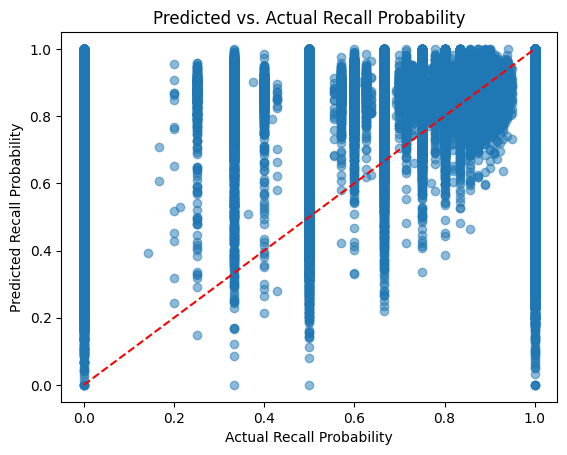

In [15]:
import matplotlib.pyplot as plt

predictions_scatterplot = plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")

In [16]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results_df.describe()

,y_test,y_pred,session_seen,session_correct
count,2501031.00000,2501031.00000,2501031.00000,2501031.00000
mean,0.89706,0.89715,1.81345,1.64149
std,0.27019,0.06421,1.35524,1.31416
min,0.00000,0.00000,1.00000,0.00000
25%,1.00000,0.87361,1.00000,1.00000
50%,1.00000,0.90781,1.00000,1.00000
75%,1.00000,0.93581,2.00000,2.00000
max,1.00000,1.00000,20.00000,20.00000


In [17]:
results = predictor.fit_summary()
results["leaderboard"]

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              XGBoost   -0.26131  root_mean_squared_error        3.16036 6383.25292                 3.16036         6383.25292            1       True          1
1  WeightedEnsemble_L2   -0.26131  root_mean_squared_error        3.16265 6383.25686                 0.00229            0.00394            2       True          2
Number of models trained: 2
Types of models trained:
{'WeightedEnsembleModel', 'XGBoostModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('category', [])                    : 1 | ['lang_combination']
('category', ['text_as_category'])  : 1 | ['tags_list']
('float', [])                       : 5 | ['SUBTLEX', 'h_recall', 'avg_delta', 'std_delta', 'avg_h_recall']
('int

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,-0.26131,root_mean_squared_error,3.16036,6383.25292,3.16036,6383.25292,1,True,1
1,WeightedEnsemble_L2,-0.26131,root_mean_squared_error,3.16265,6383.25686,0.00229,0.00394,2,True,2


In [18]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,-0.26245,-0.26131,root_mean_squared_error,55.89857,3.16036,6383.25292,55.89857,3.16036,6383.25292,1,True,1
1,WeightedEnsemble_L2,-0.26245,-0.26131,root_mean_squared_error,55.91042,3.16265,6383.25686,0.01186,0.00229,0.00394,2,True,2


In [19]:
predictor.feature_importance(test_data)

,importance,stddev,p_value,n,p99_high,p99_low
history_correct,0.03641,0.00433,0.00002,5,0.04533,0.02748
history_seen,0.02865,0.00430,0.00006,5,0.03751,0.01980
avg_delta,0.01377,0.00240,0.00011,5,0.01871,0.00883
std_delta,0.00764,0.00134,0.00011,5,0.01040,0.00488
delta,0.00688,0.00101,0.00005,5,0.00896,0.00481
avg_h_recall,0.00619,0.00163,0.00053,5,0.00955,0.00283
tags_list,0.00503,0.00083,0.00009,5,0.00674,0.00332
SUBTLEX,0.00416,0.00069,0.00009,5,0.00558,0.00275
Unnamed: 0,0.00234,0.00055,0.00034,5,0.00347,0.00121
word_len,0.00126,0.00046,0.00171,5,0.00220,0.00033


In [20]:
expanded_df = results_df.loc[results_df.index.repeat(results_df["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(results_df["session_seen"], results_df["session_correct"])
])

In [21]:
expanded_df.head()

,y_test,y_pred,session_seen,session_correct,outcome
0,1.00000,0.88966,1,1,1.00000
1,0.85714,0.87904,7,6,1.00000
2,0.85714,0.87904,7,6,1.00000
3,0.85714,0.87904,7,6,1.00000
4,0.85714,0.87904,7,6,1.00000


In [23]:
xgboost = expanded_df.drop(columns=['session_seen', 'session_correct'])

current_dir = os.getcwd()


filepath = os.path.normpath(os.path.join(current_dir, '../results/'))
xgboost.to_csv(os.path.join(filepath, 'xgboost.csv'), sep='\t', index=False, header=True)

In [ ]:
plot_calibration(expanded_df['outcome'], expanded_df['y_pred'], 'BetterXGB_calibration_plot.png')

In [ ]:
AUC_ROC(expanded_df['outcome'], expanded_df['y_pred'], 'BetterXGB_ROC_plot.png')

In [ ]:
plot_lift(expanded_df, expanded_df['y_pred'], 'BetterXGB_Lift_plot.png')